In [1]:
%load_ext autoreload 
import glob
import nibabel
import numpy as np
import cc3d

import re
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.core.debugger import set_trace
import os
import shutil
from collections import defaultdict
import pickle

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from utils import check_patch, create_dicts, trim, video_comparison, video

from celluloid import Camera
from IPython.core.display import display, HTML
%autoreload 2

In [2]:
def load(path_dict):
    results = {}
    for k,v in path_dict.items():
        results[k] = nibabel.load(v).get_fdata()
    return results

In [3]:
def patch_bbox_size(label_tensor):
    
    '''
    label_tensor - np.ndarray, with size: [H,W,D], and values in {0,1}
    '''
    
    labels_out = cc3d.connected_components(label_tensor, connectivity=26)
    u, c = np.unique(labels_out, return_counts=True)
    
    label_info[label]['cc3d'] = [u,c]
        
    mask = labels_out == 1
    
    X,Y,Z = label_tensor.shape
    
    xyz_grid = np.stack(np.meshgrid(np.arange(X), np.arange(Y), np.arange(Z), indexing='ij'), -1)
    xyz_grid = xyz_grid[mask]
    
    # fcd center
    center = xyz_grid.mean(0).astype(int)
    
    # fcd bbox sizes
    dx = (np.sum(mask, axis=(1,2)) > 0).sum()
    dy = (np.sum(mask, axis=(0,2)) > 0).sum()
    dz = (np.sum(mask, axis=(0,1)) > 0).sum()
    
    return center, dx,dy,dz

In [4]:
root = '/nfs/garfield/ibulygin/preprocessed_data_v2'
root_label = os.path.join(root, 'label')


feature_paths_templates = {
      'label':os.path.join(root, 'label/{label}.nii'),
      'mask':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
      'curv':os.path.join(root, 'curv/norm-{label}.nii'),
      'sulc':os.path.join(root, 'sulc/norm-{label}.nii'),
      'thickness':os.path.join(root, 'thickness/norm-{label}.nii'),
      'bT1':os.path.join(root, 'bluring-T1/sub-{label}_T1blurring-in-volume.nii.gz'),
      'bT2':os.path.join(root, 'bluring-T2/sub-{label}_T2blurring-in-volume.nii.gz'),
      'T1w':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'),
      'T2':os.path.join(root, 'T2/{label}.nii'),
      'CSF':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-CSF_probseg.nii.gz'),
      'GM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-GM_probseg.nii.gz'),
      'WM':os.path.join(root, 'fmriprep/sub-{label}/anat/*MNI152NLin2009cAsym_label-WM_probseg.nii.gz'),
        }

paths_dict = create_dicts(root_label,
                         feature_paths_templates, 
                         broken_labels=None,
                         validate=True)

TypeError: create_dicts() got an unexpected keyword argument 'validate'

In [217]:
result = load(paths_dict['44'])

In [219]:
for k,v in result.items():
    print(k,v.shape, v.max(), v.min())

label (241, 336, 283) 1.0 0.0
mask (241, 336, 283) 1.0 0.0
curv (241, 336, 283) 15.066107730218476 -29.17736053466797
sulc (241, 336, 283) 3.368161916732788 -3.067927598953247
thickness (241, 336, 283) 5.894205940190659 -4.474782767177767
bT1 (241, 336, 283) 89.16666666666667 0.0
bT2 (241, 336, 283) 112.66666666666667 0.0
T1w (241, 336, 283) 1485.707763671875 -68.79041290283203
T2 (241, 336, 283) 1109.1873664497746 0.0
CSF (241, 336, 283) 1.0 0.0
GM (241, 336, 283) 1.0 0.0
WM (241, 336, 283) 1.0 0.0


In [220]:
# ls /nfs/garfield/ibulygin/preprocessed_data_v2/fmriprep/sub-44/anat/ | grep space

# Visualization

In [222]:
labels = []
brains = defaultdict(list)

steps = [64,100,-64]
for k,v in tqdm(paths_dict.items()):
    brain = nibabel.load(v['T1w']).get_fdata()
    labels.append(k)
    for step in steps:
        brains[step].append(brain[:,100,:])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:43<00:00,  1.29s/it]


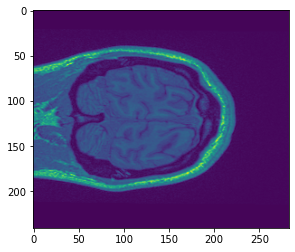

In [235]:
result = load(paths_dict['44'])
plt.imshow(result['T1w'][:,64,:])
plt.show()

/home/anadezhda/radiologist/output/nifti- bernasconi

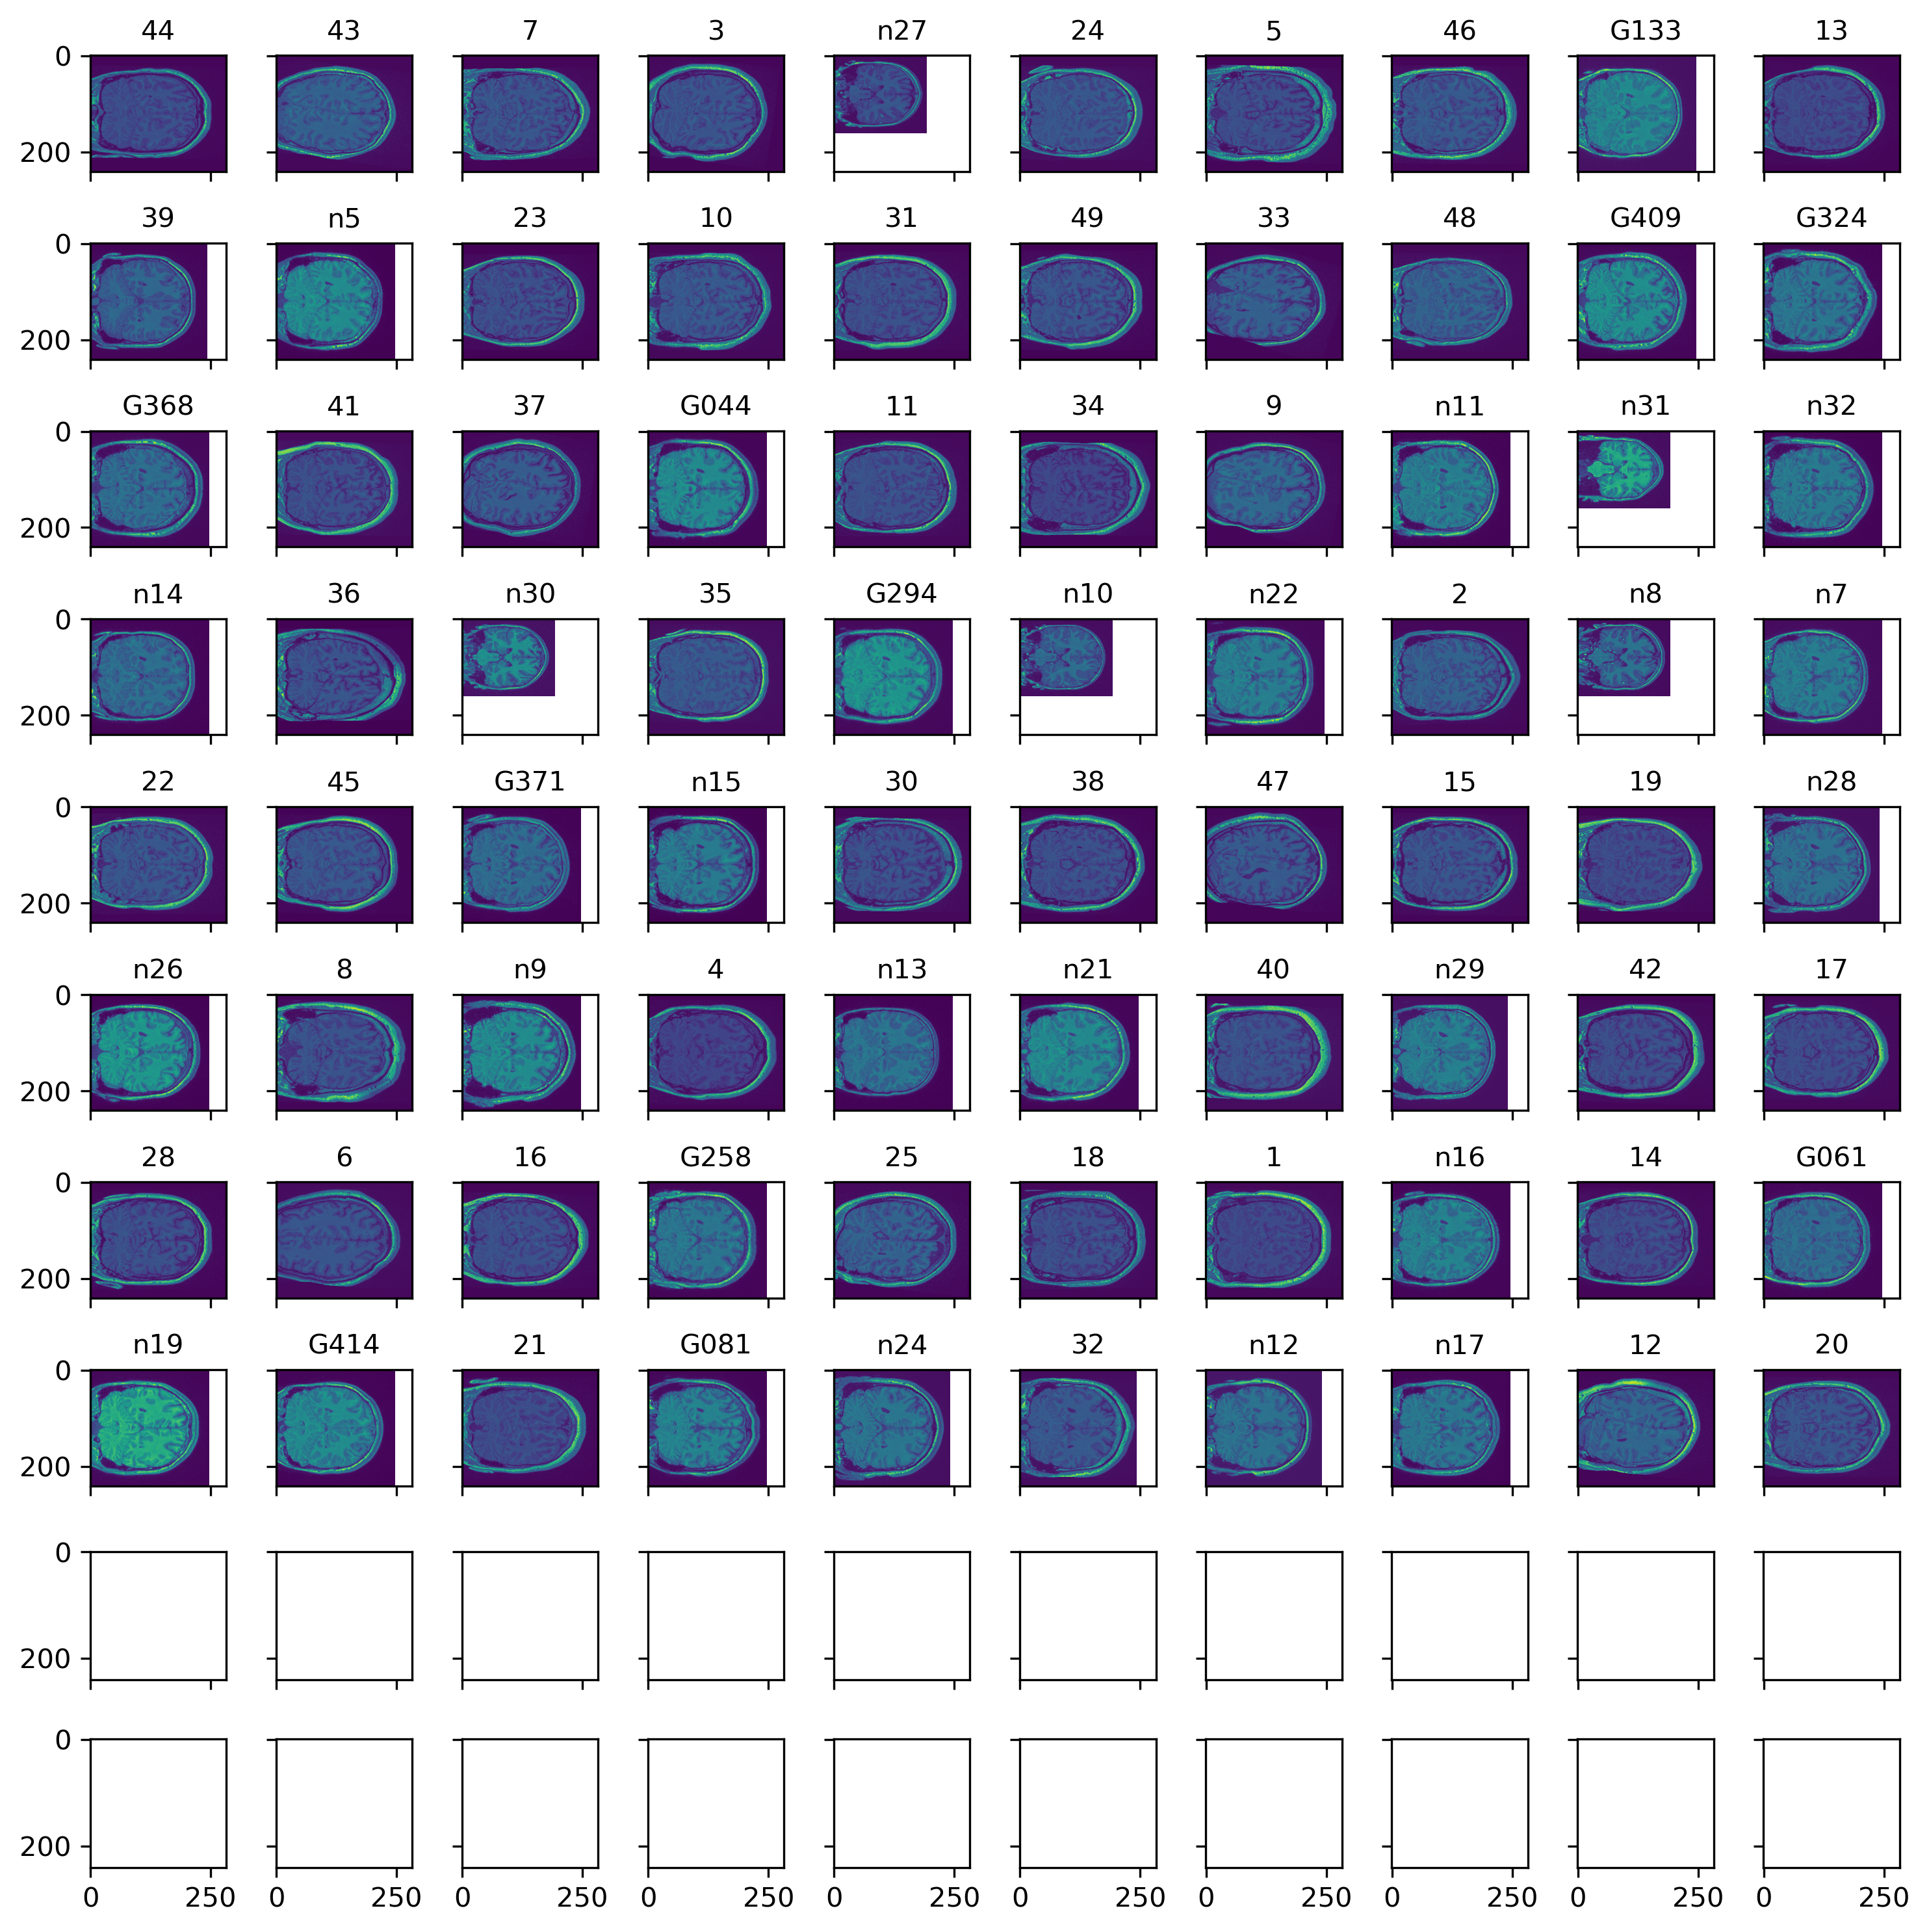

In [223]:
plt.ion()
step = steps[1]
fig, axes = plt.subplots(ncols=10, nrows=10, 
                         sharex=True, sharey=True, dpi=300, figsize=(10,10))
for i,ax in enumerate(axes.flatten()):
    try:
        ax.imshow(brains[step][i])
        ax.set_title(labels[i], fontsize=10)
    except:
        pass
plt.tight_layout()
plt.show()

# Connected components

In [231]:
label_info = defaultdict(dict)

for label, pdict in tqdm(paths_dict.items()):
    
    mask_tensor = nibabel.load(pdict['mask']).get_fdata() > 0
    mask_tensor = mask_tensor.astype(int)

    label_tensor = nibabel.load(pdict['label']).get_fdata() * mask_tensor
    label_tensor = np.array(label_tensor) > 0
    
    center,dx,dy,dz = patch_bbox_size(label_tensor)
    
    label_info[label]['d_s'] = [dx,dy,dz]
    label_info[label]['center'] = center


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [05:32<00:00,  4.16s/it]


In [232]:
# plt.imshow(mask_tensor[:,64,:])

In [234]:
np.save('label_info_v2', label_info)

In [9]:
# labels_components = np.load('labels_info.npy', allow_pickle=True).item()

In [24]:
d_max = []
k_max = []
for k,v in labels_components.items():
    if 'd_s' in v.keys():
        d_max.append(max(v['d_s']))
        k_max.append(k)

In [27]:
k_max[np.argmax(d_max)]

'n20'

In [36]:
max(d_max)

90

In [28]:
labels_components['n20']

{'cc3d': [array([0, 1], dtype=uint16), array([56343243,    42657])],
 'd_s': [39, 90, 73],
 'center': array([ 73, 336, 111])}

In [30]:
brain,mask,label = load(paths_dict['n20'])

In [32]:
brain.shape, label.shape

((215, 558, 470), (215, 558, 470))

In [37]:
from skimage import morphology

In [45]:
label_e = morphology.binary_erosion(label).astype(int)

In [47]:
label_e.sum() / label.sum()

0.7763790233724829

In [46]:
plt.ioff()
camera = video(brain,
               label_e,
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation